In [7]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import cm ,colors
from sklearn.manifold import MDS
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import squareform,pdist
from scipy.stats import zscore
from scipy.io import loadmat
from utils.eval import rotate, gen_behav_models, compute_congruency_acc, make_dataset, fit_model_to_subjects, compute_behav_taskfact, gen_modelrdms
from utils.plotting import plot_MDS_embeddings_2D, disp_model_estimates
from sklearn.decomposition import PCA
from copy import deepcopy
import typing
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure 1: Experiment design and baselines

In [106]:
with open('checkpoints/baseline_interleaved_new/run_1/results.pkl', 'rb') as f:
    results = pickle.load(f)


<ipython-input-38-a60966855d0e>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = plt.axes([0.85, 0.1, 0.075, 0.8])
<ipython-input-38-a60966855d0e>:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f4.tight_layout()


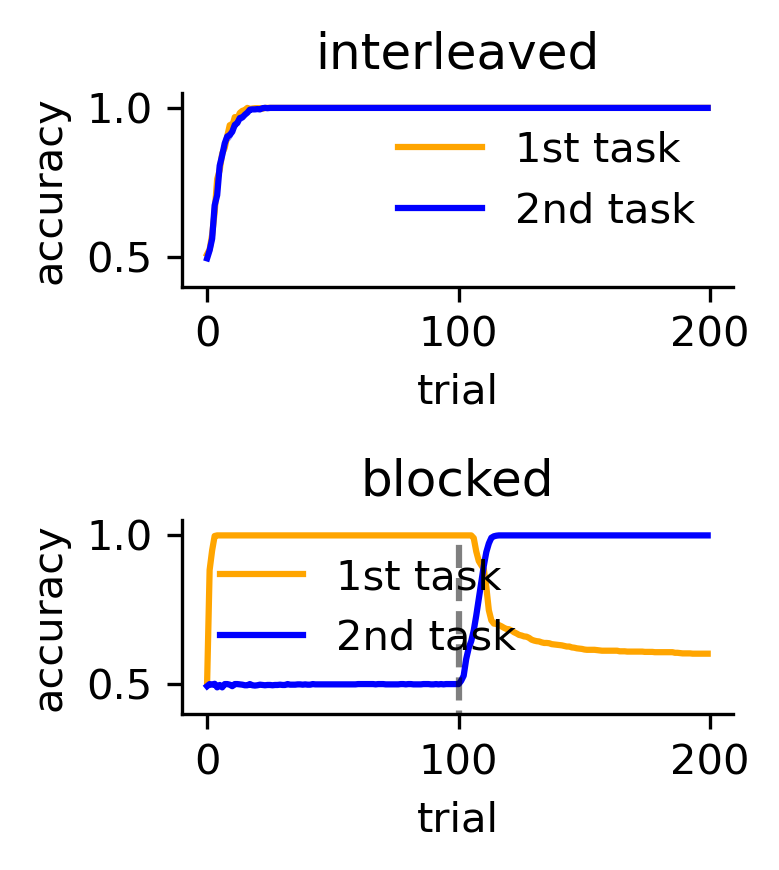

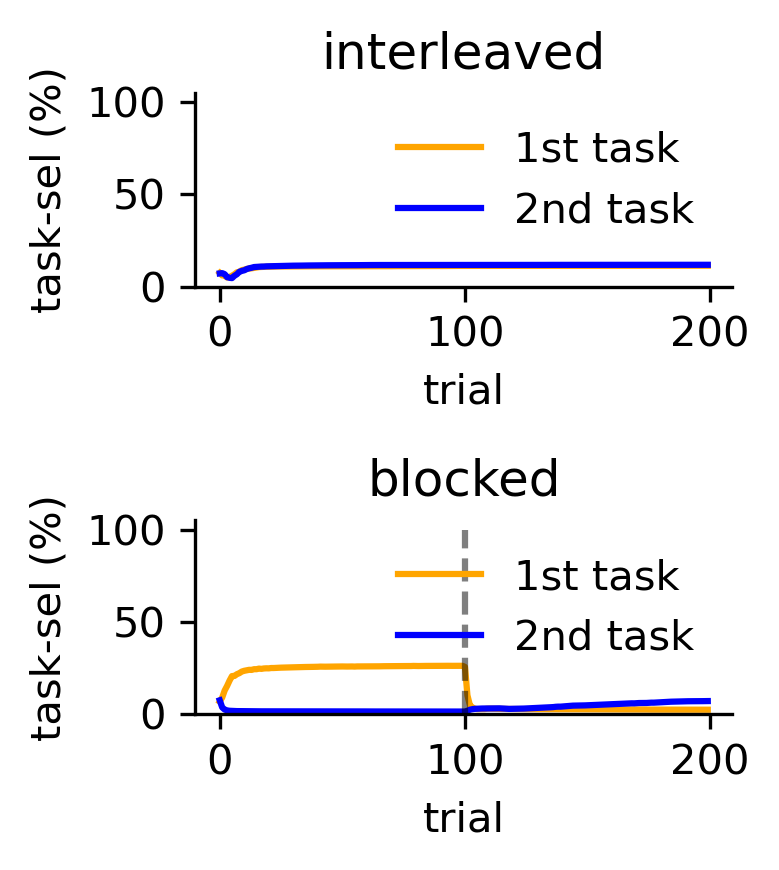

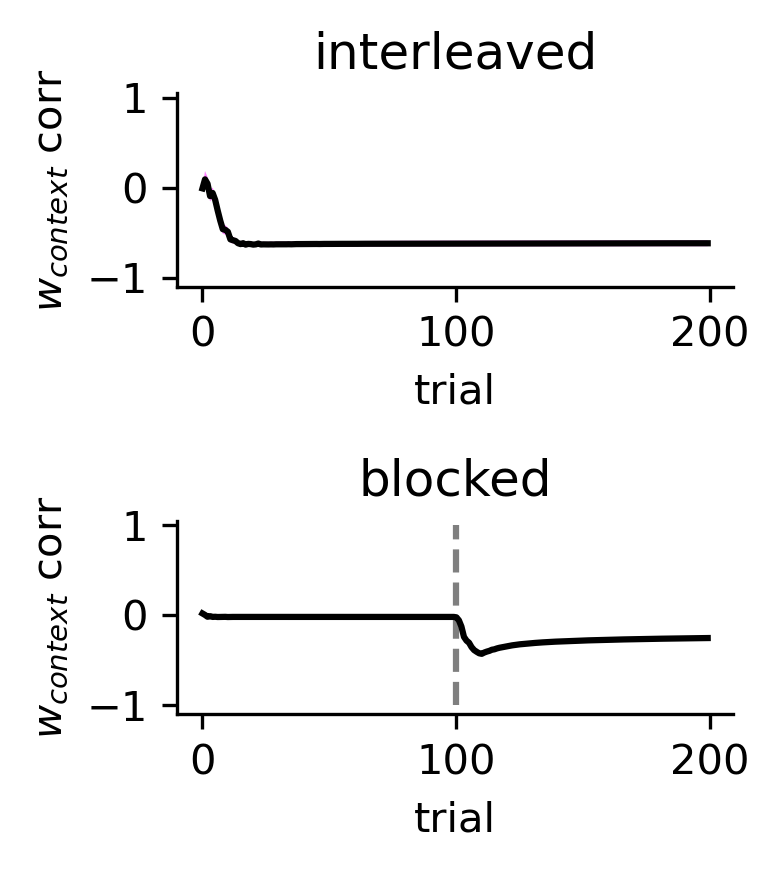

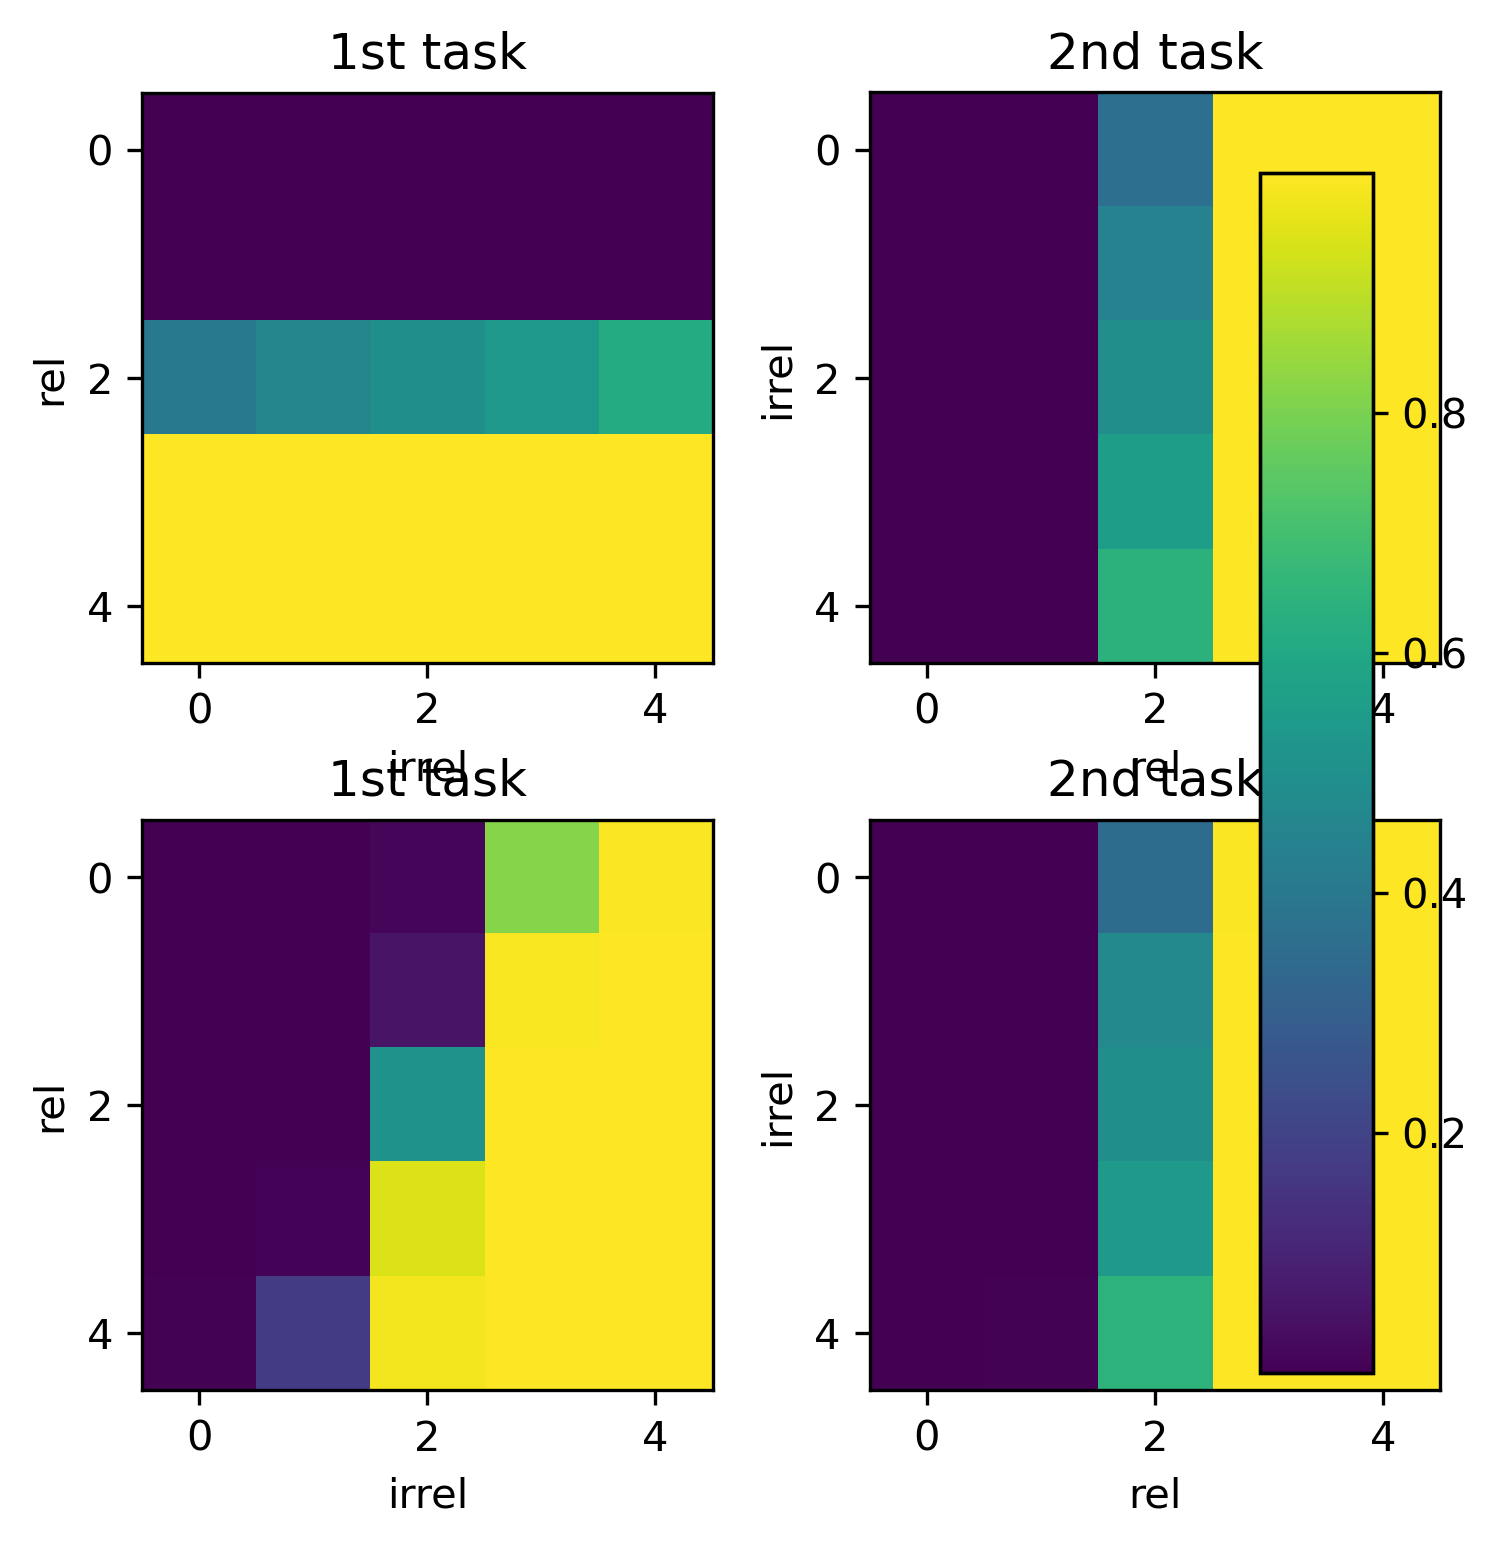

In [38]:
%matplotlib inline
n_runs = 50
models = ['baseline_interleaved_new_select','baseline_blocked_new_select'] #pilot_bs_int_lowsigma

# acc
f1, axs1 = plt.subplots(2,1,figsize=(2.7,3),dpi=300)
# # unit alloc
f2, axs2 = plt.subplots(2,1,figsize=(2.7,3),dpi=300)
# # context corr 
f3, axs3 = plt.subplots(2,1,figsize=(2.7,3),dpi=300)
# # choice matrices 
f4, axs4 = plt.subplots(2,2,figsize=(5,5),dpi=300)
# # hidden layer MDS, interleaved
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)
# # hidden layer MDS, blocked
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)


for i,m in enumerate(models):
    t_a = np.empty((n_runs,200))
    t_b = np.empty((n_runs,200))
    t_d = np.empty((n_runs,200))
    t_mixed = np.empty((n_runs,200))
    acc_1st = np.empty((n_runs,200))
    acc_2nd = np.empty((n_runs,200))
    contextcorr = np.empty((n_runs,200))
    cmats_a = []
    cmats_b = []

    for r in range(n_runs):
        with open('checkpoints/'+m+'/run_'+str(r)+'/results.pkl', 'rb') as f:
            results = pickle.load(f)
            
            # accuracy:
            acc_1st[r,:] = results['acc_1st']
            acc_2nd[r,:] = results['acc_2nd']
            # task factorisation:
            t_a[r,:] = results['n_only_b_regr']/100
            t_b[r,:] = results['n_only_a_regr']/100
            t_d[r,:] = results['n_dead']/100
            t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
            # context correlation:
            contextcorr[r,:] = results['w_context_corr']
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
            choices = 1/(1+np.exp(-cc))
            cmats_a.append(choices[:25].reshape(5,5))
            cmats_b.append(choices[25:].reshape(5,5))
            
    cmats_a = np.array(cmats_a)
    cmats_b = np.array(cmats_b)
    
    # accuracy
    axs1[i].plot(np.arange(200),acc_1st.mean(0),color='orange')
    axs1[i].fill_between(np.arange(200),acc_1st.mean(0)-np.std(acc_1st,0)/np.sqrt(n_runs),acc_1st.mean(0)+np.std(acc_1st,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs1[i].plot(np.arange(200),acc_2nd.mean(0),color='blue')
    axs1[i].fill_between(np.arange(200),acc_2nd.mean(0)-np.std(acc_2nd,0)/np.sqrt(n_runs),acc_2nd.mean(0)+np.std(acc_2nd,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    axs1[i].set_ylim([0.4,1.05])
    axs1[i].set(xlabel='trial', ylabel='accuracy')
    axs1[i].legend(['1st task','2nd task'],frameon=False)
    if 'interleaved' not in m:
        axs1[i].plot([100,100],[0,1],'k--',alpha=0.5)
    axs1[i].set_title(m.split('_')[1])
    plt.gcf()
    sns.despine(f1)
    f1.tight_layout()

    # unit allocation (task factorisation)
    axs2[i].plot(np.arange(200),t_b.mean(0),color='orange')
    axs2[i].fill_between(np.arange(200),t_b.mean(0)-np.std(t_b,0)/np.sqrt(n_runs),t_b.mean(0)+np.std(t_b,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs2[i].plot(np.arange(200),t_a.mean(0),color='blue')
    axs2[i].fill_between(np.arange(200),t_a.mean(0)-np.std(t_a,0)/np.sqrt(n_runs),t_a.mean(0)+np.std(t_a,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)    
    axs2[i].set_yticks([0,0.5,1])
    ticks = axs2[i].get_yticks()#plt.yticks()
    axs2[i].set_yticklabels((int(x) for x in ticks*100))
    axs2[i].set(xlabel='trial',ylabel='task-sel (%)')
    axs2[i].legend(['1st task','2nd task'],frameon=False)
    if 'interleaved' not in m:
        axs2[i].plot([100,100],[0,1],'k--',alpha=0.5)
    axs2[i].set_title(m.split('_')[1])
    plt.gcf()
    sns.despine(f2)
    axs2[i].set_ylim([0,1.05])    
    f2.tight_layout()

    # context corr 
    axs3[i].plot(np.arange(200),contextcorr.mean(0),color='k')    
    axs3[i].fill_between(np.arange(200),contextcorr.mean(0)-np.std(contextcorr,0)/np.sqrt(n_runs),contextcorr.mean(0)+np.std(contextcorr,0)/np.sqrt(n_runs),alpha=0.5,color='magenta',edgecolor=None)
    
    axs3[i].set_ylim([-1.1,1.05])
    axs3[i].set(xlabel='trial',ylabel=r'$w_{context}$ corr ')    
    if 'interleaved' not in m:
        axs3[i].plot([100,100],[-1,1],'k--',alpha=0.5)
    axs3[i].set_title(m.split('_')[1])
    sns.despine(f3)
    f3.tight_layout()


    # choice matrices 
    
    axs4[i,0].imshow(cmats_a.mean(0))
    axs4[i,0].set_title('1st task')
    axs4[i,0].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='irrel',ylabel='rel')
    axs4[i,1].imshow(cmats_b.mean(0))
    axs4[i,1].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='rel',ylabel='irrel')
    axs4[i,1].set_title('2nd task')
    PCM=axs4[i,1].get_children()[-2] #get the mappable, the 1st and the 2nd are the x and y axes
    
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(PCM,cax=cax)      


    # hidden layer MDS 

f1.tight_layout()
f2.tight_layout()
f3.tight_layout()
f4.tight_layout()



In [6]:
results['all_y_hidden'].shape

(2, 50, 100)

In [31]:
# interleaved, baseline
# n_runs = 50
# rdms = np.empty((n_runs,50,50))
# for r in range(n_runs):
#     with open('checkpoints/baseline_interleaved_new/run_'+str(r)+'/results.pkl', 'rb') as f:
#         results = pickle.load(f)
#     rdms[r,:,:] = squareform(pdist(results['all_y_hidden'][-1,:,:],metric='euclidean'))


# embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True,dissimilarity='precomputed')


# xyz = embedding.fit_transform(np.mean(rdms,0))
# with open('mds_embedding_baseline_int_new.pkl','wb') as f:
#     pickle.dump(xyz, f)


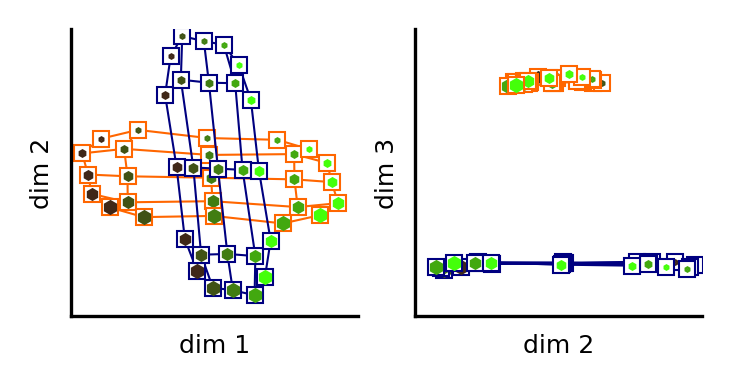

In [56]:
%matplotlib inline
with open('mds_embedding_baseline_int_new.pkl','rb') as f:
    xyz = pickle.load(f)
theta_x = 40
theta_y = 0
theta_z = 10

xyz_rot = rotate(xyz,theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=5)

In [41]:
# # blocked, baseline
# n_runs = 50
# rdms = np.empty((n_runs,50,50))
# for r in range(n_runs):
#     with open('checkpoints/baseline_blocked_new/run_'+str(r)+'/results.pkl', 'rb') as f:
#         results = pickle.load(f)
#     rdms[r,:,:] = squareform(pdist(results['all_y_hidden'][-1,:,:],metric='euclidean'))


# embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True,dissimilarity='precomputed')


# xyz = embedding.fit_transform(np.mean(rdms,0))
# with open('mds_embedding_baseline_blocked_new.pkl','wb') as f:
#     pickle.dump(xyz, f)

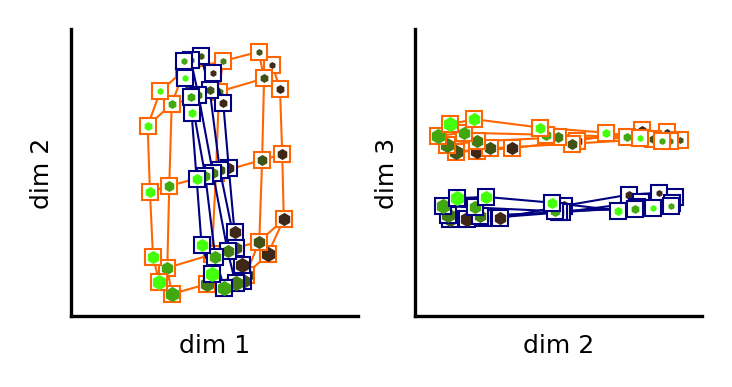

In [57]:

%matplotlib inline
with open('mds_embedding_baseline_blocked_new.pkl','rb') as f:
    xyz = pickle.load(f)
theta_x = -10
theta_y = -10
theta_z = -70

xyz_rot = rotate(xyz,theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=4)

## Figure 2: The cost of interleaving

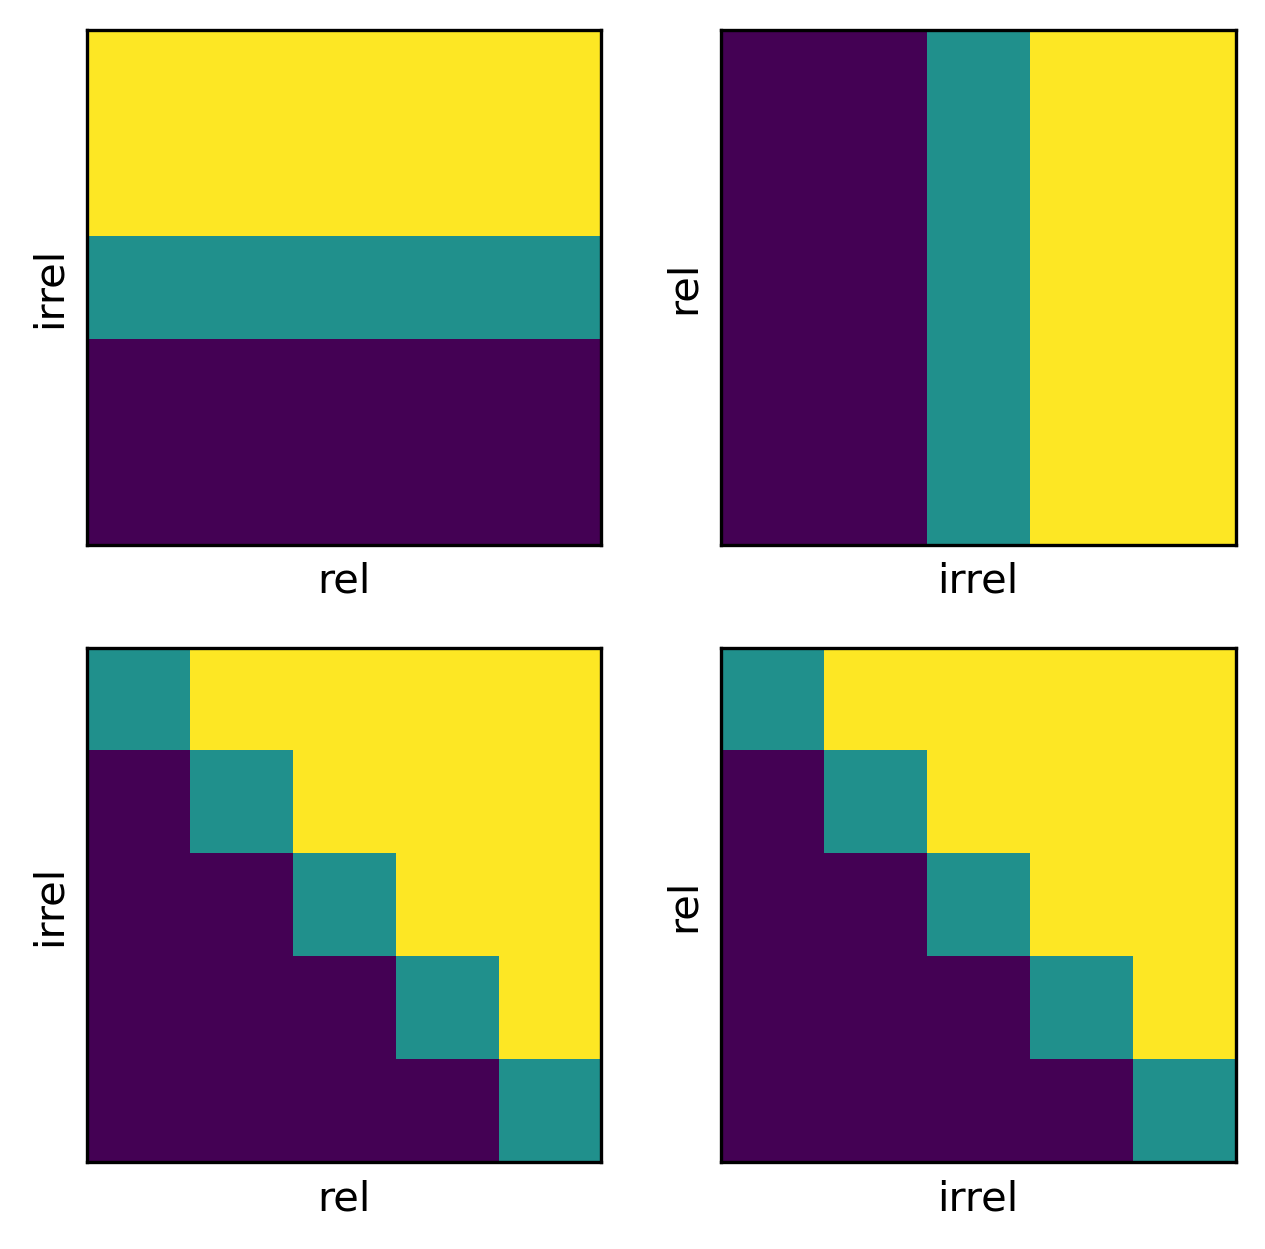

In [7]:
# choice matrix models


%matplotlib inline
_,_,cmats = gen_behav_models()

f,ax = plt.subplots(2,2, figsize=(5,5),dpi=300)
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(np.flipud(cmats[i,j,:,:]))
        if j<1:
            ax[i,j].set(xlabel='rel',ylabel='irrel')
        else:
            ax[i,j].set(xlabel='irrel',ylabel='rel')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])


In [8]:
# accuracy (sluggishness)
%matplotlib qt
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]
cols = cm.plasma([0.05,0.1, 0.2, 0.3, 0.4, 0.7, 0.9])


n_runs = 50 
f,axs = plt.subplots(1,1,figsize=(3,2.56),dpi=300)

accs = []
for pli,ii,sv,col in zip(np.arange(len(idces)),idces,alphas_to_plot,cols):
    acc_a = []
    acc_b = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_select_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            acc_a.append(results['acc_1st'][-1])
            acc_b.append(results['acc_2nd'][-1])
    accs.append((np.array(acc_a)+np.array(acc_b))/2)
accs = np.flipud(np.array(accs))
for acc,pli,ii,sv,col in zip(accs,np.arange(len(idces)),idces,alphas_to_plot,cols):
    plt.bar(pli,acc.mean(),yerr=np.std(acc)/np.sqrt(n_runs),color=col)    
    sns.despine()

plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title('Accuracy')
plt.xticks(ticks=np.arange(7),labels=np.array(1-np.fliplr(np.asarray([alphas_to_plot]))[0]).round(2))
plt.yticks(np.arange(0.4,1.1,0.2),labels=[int(x) for x in (np.arange(0.4,1.1,0.2)*100)])
plt.ylabel('accuracy (%)')
plt.ylim(0.4,1)
plt.tight_layout()
    

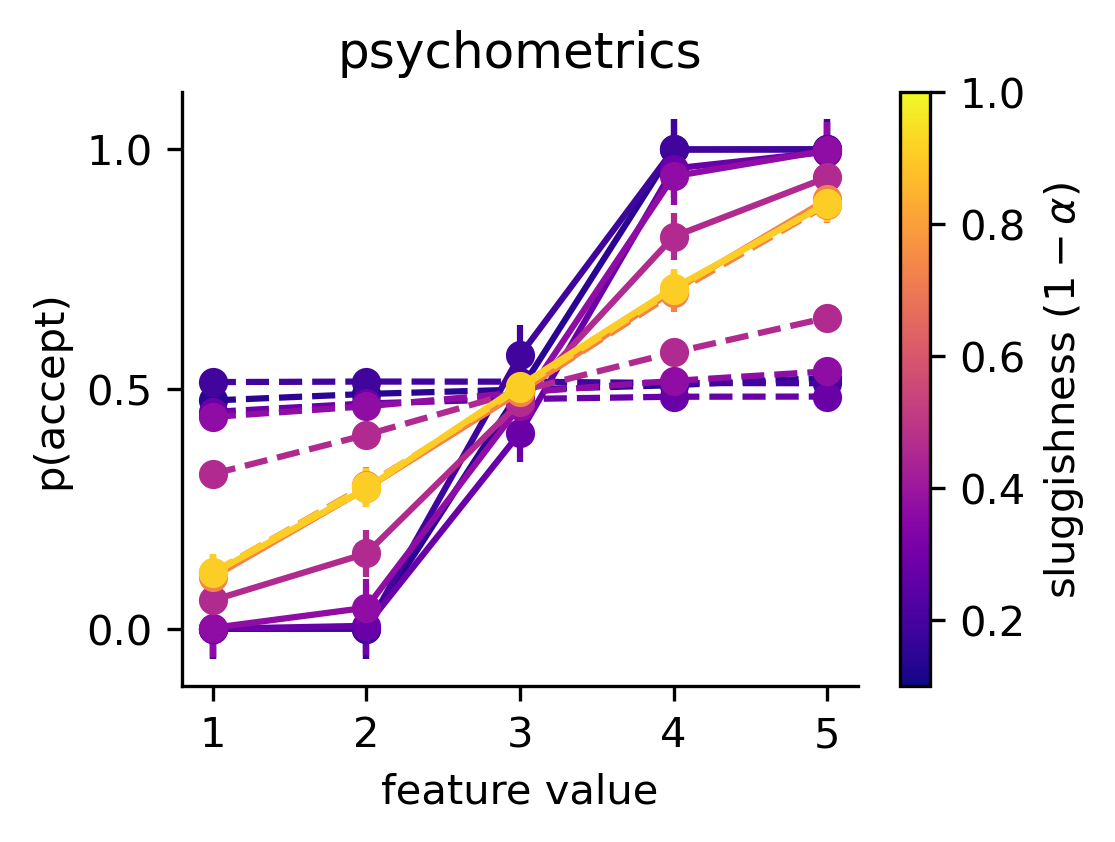

In [5]:
# sigmoids 
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]
cols = cm.plasma([0.05,0.1, 0.2, 0.3, 0.4, 0.7, 0.9])


n_runs = 50 
f,axs = plt.subplots(1,1,figsize=(3.81,2.91),dpi=300)

all_choices_rel = []
all_choices_irrel = []
for ii,sv,col in zip(idces,alphas_to_plot,cols):
    cmats_a = []
    cmats_b = []
    corrs_run_b = []
    corrs_run_i = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_select_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
            choices = 1/(1+np.exp(-cc))
            cmats_a.append(choices[:25].reshape(5,5))
            cmats_b.append(choices[25:].reshape(5,5))
            
    cmats_a = np.array(cmats_a)
    cmats_b = np.array(cmats_b)
    choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
    choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
    all_choices_rel.append(choices_rel)
    all_choices_irrel.append(choices_irrel)
all_choices_rel.reverse()
all_choices_irrel.reverse()
for choices_rel,choices_irrel,ii,sv,col in zip(all_choices_rel,all_choices_irrel,idces,alphas_to_plot,cols):
    plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='o',color=col)
    plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='o',color=col,linestyle='--')
    sns.despine()
cmap = cm.plasma
norm = colors.Normalize(vmin=0.1, vmax=1)

plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
              label=r'sluggishness ($1-\alpha$)')
plt.title('psychometrics')
plt.xlabel('feature value')
plt.yticks(ticks=[0,0.5,1])
plt.xticks(ticks=np.arange(5),labels=[1,2,3,4,5])
plt.ylabel('p(accept)')
plt.tight_layout()
    

In [7]:
# choice matrices
#labels: task (1st,2nd) on left, gradient arrow with slugg along x, coloured frames around cmats for clarification, cbar on right with p(choice)
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]

unit_cols = [[250/255, 147/255, 30/255],[0/255, 6/255, 189/255],[4/255, 162/255, 201/255]]

n_runs = 50 
f,axs = plt.subplots(2,7,figsize=(10,4))
all_cmats_a = []
all_cmats_b = []

for ax1,ax2,ii,sv in zip(axs[0,:],axs[1,:],idces,alphas_to_plot):
    cmats_a = []
    cmats_b = []
    corrs_run_b = []
    corrs_run_i = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_select_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
            choices = 1/(1+np.exp(-cc))
            cmats_a.append(choices[:25].reshape(5,5))
            cmats_b.append(choices[25:].reshape(5,5))
            
    cmats_a = np.array(cmats_a)
    cmats_b = np.array(cmats_b)
    all_cmats_a.append(cmats_a)
    all_cmats_b.append(cmats_b)
all_cmats_a.reverse()
all_cmats_b.reverse()
alphas_to_plot.reverse()
for cmats_a,cmats_b,ax1,ax2,ii,sv in zip(all_cmats_a,all_cmats_b,axs[0,:],axs[1,:],idces,alphas_to_plot):
    ax1.imshow(np.flipud(cmats_a.mean(0)))
    # ax1.set_title(r'$1-\alpha=$%s'%np.round(1-sv,2))
    # ax1.set_title('1st task')
    ax1.set(xticks=[0,2,4],yticks=[0,2,4],xlabel='irrel',ylabel='rel')
    [i.set_linewidth(3) for i in ax1.spines.values()]
    [i.set_color(unit_cols[0]) for i in ax1.spines.values()]
    ax2.imshow(np.flipud(cmats_b.mean(0)))
    ax2.set(xticks=[0,2,4],yticks=[0,2,4],xlabel='rel',ylabel='irrel')
    # ax2.set_title(r'$1-\alpha=$%s'%np.round(1-sv,2))
    # ax2.set_title('2nd task')
    [i.set_linewidth(3) for i in ax2.spines.values()]
    [i.set_color(unit_cols[1]) for i in ax2.spines.values()]
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
plt.tight_layout()



In [8]:
# task factorisation
%matplotlib qt
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alphas_to_plot = [0.05,0.1, 0.2, 0.3, 0.4, 0.7, 1]
idces = [np.where(alp==sluggish_vals)[0][0] for alp in alphas_to_plot]

unit_cols = [[250/255, 147/255, 30/255],[0/255, 6/255, 189/255],[4/255, 162/255, 201/255]]

n_runs = 50 

rdms,dmat,_ = gen_behav_models()

all_betas = []
for ii,sv in zip(idces,alphas_to_plot):
    betas = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_select_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        yrdm = squareform(pdist(choices))

        y = zscore(yrdm[np.tril_indices(50,k=-1)]).flatten()
        assert len(y)==1225
        lr = LinearRegression()
        lr.fit(dmat,y)            
        betas.append(lr.coef_)
    all_betas.append(betas)
all_betas.reverse()
all_betas = np.array(all_betas)
all_betas.shape

plt.figure(figsize=(3.8,2.9),dpi=300)
for i in range(len(all_betas)):
    ha = plt.bar(i-0.2,np.mean(all_betas[i,:,0],0),yerr=np.std(all_betas[i,:,0],0)/np.sqrt(all_betas.shape[1]),width=0.4,color='darkblue')
    hb = plt.bar(i+0.2,np.mean(all_betas[i,:,1],0),yerr=np.std(all_betas[i,:,1],0)/np.sqrt(all_betas.shape[1]),width=0.4,color='darkgreen')
    sns.despine()
plt.legend([ha,hb],('factorised model','linear model'),frameon=False)
plt.ylabel(r'$\beta$ coefficient (a.u.)')
plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title('Choice Factorisation')
plt.xticks(ticks=np.arange(7),labels=np.array(1-np.fliplr(np.asarray([alphas_to_plot]))[0]).round(2))


([<matplotlib.axis.XTick at 0x254cab1be80>,
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.3'),
  Text(2, 0, '0.6'),
  Text(3, 0, '0.7'),
  Text(4, 0, '0.8'),
  Text(5, 0, '0.9'),
  Text(6, 0, '0.95')])

In [13]:

plt.imshow(cmats[0,1])

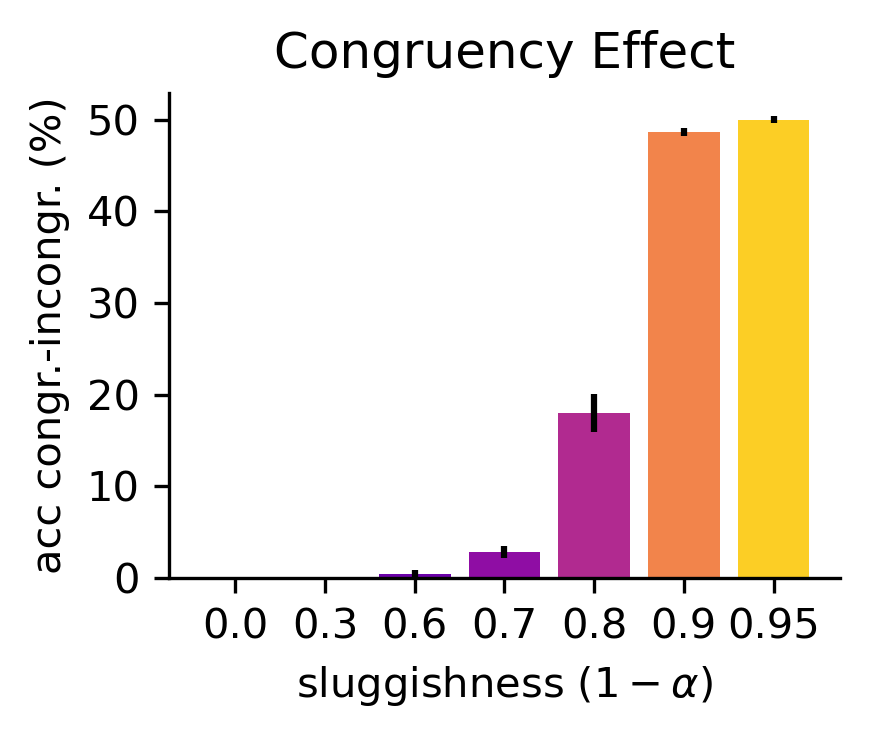

In [21]:
# congruency effect
%matplotlib inline
n_runs = 50 

all_accs = []
_,_,cmats = gen_behav_models()
cmat_a = cmats[0,0,:,:]
cmat_b = cmats[0,1,:,:]

for ii,sv in zip(idces,alphas_to_plot):
    accs = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_select_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        choices = choices.reshape((2,5,5))
        choices_a = choices[0,:,:]
        choices_b = choices[1,:,:]        
        acc,aci = compute_congruency_acc(choices_a,cmat_a)        
        acc_a = acc-aci
        acc,aci = compute_congruency_acc(choices_b,cmat_b)
        acc_b = acc-aci
        accs.append((acc_a+acc_b)/2)
        
    all_accs.append(accs)
all_accs.reverse()
all_accs = np.array(all_accs)

plt.figure(figsize=(3,2.56),dpi=300)
for acc,pli,ii,sv,col in zip(all_accs,np.arange(len(idces)),idces,alphas_to_plot,cols):
    plt.bar(pli,acc.mean(),yerr=np.std(acc)/np.sqrt(n_runs),color=col)    
    sns.despine()

plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title('Congruency Effect')
plt.xticks(ticks=np.arange(7),labels=np.array(1-np.fliplr(np.asarray([alphas_to_plot]))[0]).round(2))
plt.yticks(np.arange(0,0.55,0.1),labels=[int(x) for x in (np.arange(0,0.55,0.1)*100)])
plt.ylabel('acc congr.-incongr. (%)')
# plt.ylim(0.4,1)
plt.tight_layout()

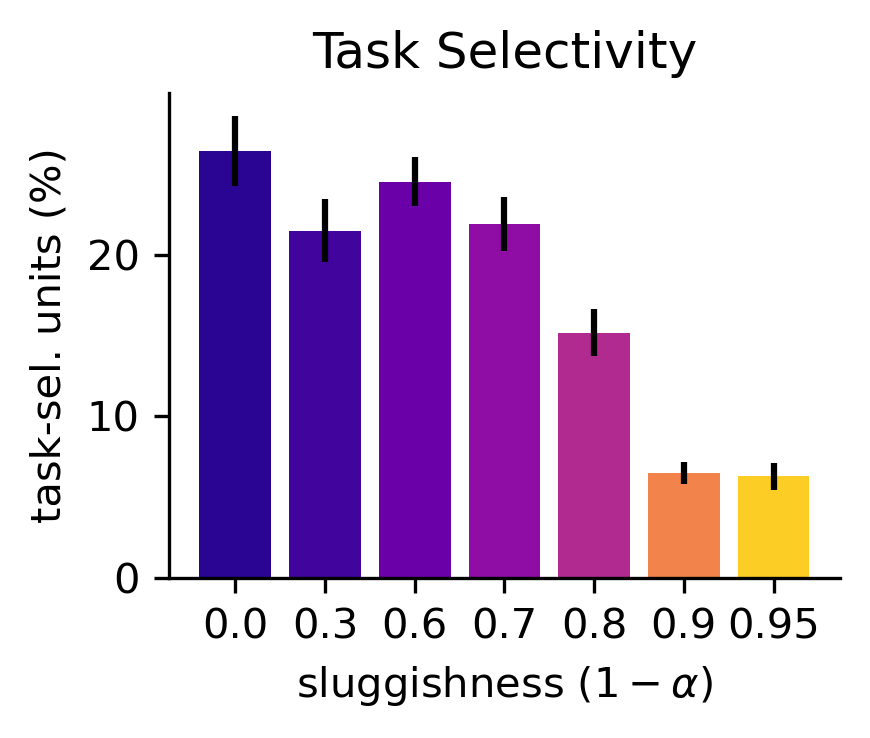

In [32]:
# unit selectivity
# %matplotlib qt
n_runs = 50 

all_n_local = []
for ii,sv in zip(idces,alphas_to_plot):
    n_local = []
    for r in np.arange(0,n_runs):
        with open('checkpoints/sluggish_baseline_int_select_sv'+ str(ii) + '/run_' + str(r) +'/results.pkl','rb') as f:
            results = pickle.load(f)
        n_local.append(results['n_only_a_regr'][-1]+results['n_only_b_regr'][-1])
        
    all_n_local.append(n_local)
all_n_local.reverse()
all_n_local = np.array(all_n_local)

plt.figure(figsize=(3,2.56),dpi=300)
for n_loc,pli,ii,sv,col in zip(all_n_local,np.arange(len(idces)),idces,alphas_to_plot,cols):
    plt.bar(pli,n_loc.mean(),yerr=np.std(n_loc)/np.sqrt(n_runs),color=col)    
    sns.despine()

plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title('Task Selectivity')
plt.xticks(ticks=np.arange(7),labels=np.array(1-np.fliplr(np.asarray([alphas_to_plot]))[0]).round(2))
# plt.yticks(np.arange(0,0.55,0.1),labels=[int(x) for x in (np.arange(0,0.55,0.1)*100)])
plt.ylabel('task-sel. units (%)')
# plt.ylim(0.4,1)
plt.tight_layout()

## Figure 3: continual learning with manual gating

In [27]:
# learning curves 
%matplotlib qt
n_runs = 50
models = ['gated_blocked_new_select_cent']

# acc
f1, axs1 = plt.subplots(1,1,figsize=(2.7,2),dpi=300)
f2, axs2 = plt.subplots(1,1,figsize=(2.7,2),dpi=300)
# # choice matrices 
f4, axs4 = plt.subplots(1,2,figsize=(5,5),dpi=300)
# # hidden layer MDS, interleaved
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)
# # hidden layer MDS, blocked
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)


for i,m in enumerate(models):
    t_a = np.empty((n_runs,200))
    t_b = np.empty((n_runs,200))
    t_d = np.empty((n_runs,200))
    t_mixed = np.empty((n_runs,200))
    acc_1st = np.empty((n_runs,200))
    acc_2nd = np.empty((n_runs,200))
    contextcorr = np.empty((n_runs,200))
    cmats_a = []
    cmats_b = []

    for r in range(n_runs):
        with open('checkpoints/'+m+'/run_'+str(r)+'/results.pkl', 'rb') as f:
            results = pickle.load(f)
            
            # accuracy:
            acc_1st[r,:] = results['acc_1st']
            acc_2nd[r,:] = results['acc_2nd']
            # task factorisation:
            t_a[r,:] = results['n_only_b_regr']/100
            t_b[r,:] = results['n_only_a_regr']/100
            t_d[r,:] = results['n_dead']/100
            t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
            # context correlation:
            contextcorr[r,:] = results['w_context_corr']
            cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
            choices = 1/(1+np.exp(-cc))
            cmats_a.append(choices[:25].reshape(5,5))
            cmats_b.append(choices[25:].reshape(5,5))
            
    cmats_a = np.array(cmats_a)
    cmats_b = np.array(cmats_b)
    
    # accuracy
    axs1.plot(np.arange(200),acc_1st.mean(0),color='orange')
    axs1.fill_between(np.arange(200),acc_1st.mean(0)-np.std(acc_1st,0)/np.sqrt(n_runs),acc_1st.mean(0)+np.std(acc_1st,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs1.plot(np.arange(200),acc_2nd.mean(0),color='blue')
    axs1.fill_between(np.arange(200),acc_2nd.mean(0)-np.std(acc_2nd,0)/np.sqrt(n_runs),acc_2nd.mean(0)+np.std(acc_2nd,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
    axs1.set_ylim([0.4,1.05])
    axs1.set(xlabel='trial', ylabel='accuracy')
    axs1.legend(['1st task','2nd task'],frameon=False)
    if 'interleaved' not in m:
        axs1.plot([100,100],[0,1],'k--',alpha=0.5)
    axs1.set_title(m.split('_')[1])
    plt.gcf()
    sns.despine(f1)
    f1.tight_layout()

    # unit allocation
    # unit allocation (task factorisation)
    axs2.plot(np.arange(200),t_b.mean(0),color='orange')
    axs2.fill_between(np.arange(200),t_b.mean(0)-np.std(t_b,0)/np.sqrt(n_runs),t_b.mean(0)+np.std(t_b,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
    axs2.plot(np.arange(200),t_a.mean(0),color='blue')
    axs2.fill_between(np.arange(200),t_a.mean(0)-np.std(t_a,0)/np.sqrt(n_runs),t_a.mean(0)+np.std(t_a,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)    
    axs2.set_yticks([0,0.5,1])
    ticks = axs2.get_yticks()#plt.yticks()
    axs2.set_yticklabels((int(x) for x in ticks*100))
    axs2.set(xlabel='trial',ylabel='task-sel (%)')
    axs2.legend(['1st task','2nd task'],frameon=False)
    if 'interleaved' not in m:
        axs2.plot([100,100],[0,1],'k--',alpha=0.5)
    axs2.set_title(m.split('_')[1])
    plt.gcf()
    sns.despine(f2)
    axs2.set_ylim([0,1.05])    
    f2.tight_layout()

    # choice matrices    
    axs4[0].imshow(cmats_a.mean(0))
    axs4[0].set_title('1st task')
    axs4[0].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='irrel',ylabel='rel')
    axs4[1].imshow(cmats_b.mean(0))
    axs4[1].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='rel',ylabel='irrel')
    axs4[1].set_title('2nd task')
    PCM=axs4[1].get_children()[-2] #get the mappable, the 1st and the 2nd are the x and y axes
    axs4[0].set_xticks([])
    axs4[0].set_yticks([])
    axs4[1].set_xticks([])
    axs4[1].set_yticks([])
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    # plt.colorbar(PCM,cax=cax) 

    # hidden layer MDS 

f1.tight_layout()
f2.tight_layout()
f3.tight_layout()
f4.tight_layout()



In [197]:
# hidden layer MDS
# blocked, manual gated
# n_runs = 50
# rdms = np.empty((n_runs,50,50))
# for r in range(n_runs):
#     with open('checkpoints/gated_blocked_new/run_'+str(r)+'/results.pkl', 'rb') as f:
#         results = pickle.load(f)
#     rdms[r,:,:] = squareform(pdist(results['all_y_hidden'][-1,:,:],metric='euclidean'))


# embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True,dissimilarity='precomputed')


# xyz = embedding.fit_transform(np.mean(rdms,0))
# with open('mds_embedding_gated_blocked_new.pkl','wb') as f:
#     pickle.dump(xyz, f)
%matplotlib qt
with open('mds_embedding_gated_blocked_new.pkl','rb') as f:
    xyz = pickle.load(f)
theta_x = -20
theta_y = -20
theta_z = -60-90

xyz_rot = rotate(xyz,theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=5.2)

## Figure 4: Hebbian learning of context weights, SLA 

27


Text(0.5, 1.0, 'Biplot')

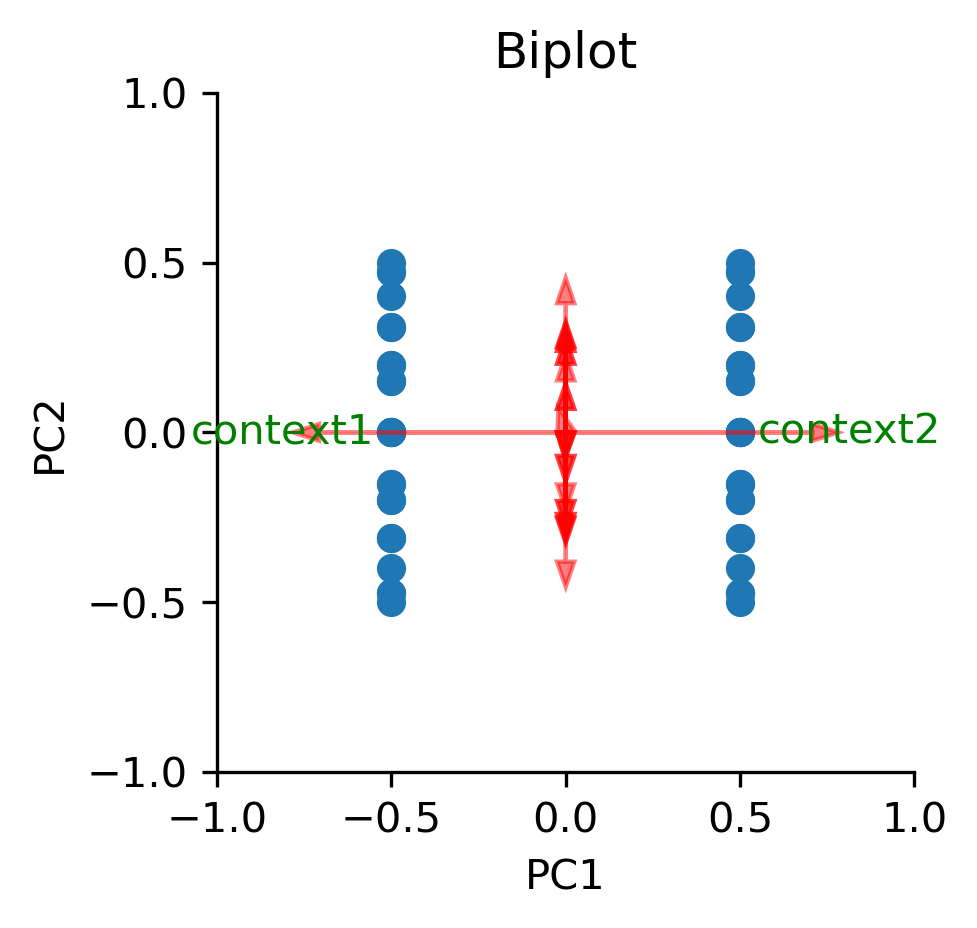

In [3]:
# biplot
%matplotlib inline
pca = PCA(n_components=27)
data = make_dataset(n_episodes=1,ctx_scaling=5,ctx_avg=False,centering=True)


pca.fit(data['x_train'])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scores = data['x_train']@pca.components_.T
labels = ['']*25 + ['context1'] + ['context2']




score = scores
coeff = pca.components_.T
pcax = 1
pcay =2

plt.figure(figsize=(3,3),dpi=300)

pca1=pcax-1
pca2=pcay-1
xs = score[:,pca1]
ys = score[:,pca2]
n=score.shape[1]
scalex = 1.0/(xs.max()- xs.min())
scaley = 1.0/(ys.max()- ys.min())
plt.scatter(xs*scalex,ys*scaley)
print(n)
for i in range(n):
    plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5, head_width=0.05) 
    if labels is None:
        plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
    else:
        plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xticks(np.arange(-1,1.1,0.5))
plt.yticks(np.arange(-1,1.1,0.5))
plt.xlabel("PC{}".format(pcax))
plt.ylabel("PC{}".format(pcay))
# plt.grid()
sns.despine()
plt.title('Biplot')

In [35]:
# oja's rule 
eta = 4e-2
sigma = 1e-2
n_episodes = 1
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False)
w = np.random.randn(27)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(w))
X = data['x_train']
for x in X:
    y = w.T@x    
    dw = eta*y*(x-y*w.T)    
    w += dw
    delta_ws.append(dw)
    ws.append(deepcopy(w))

plt.figure(figsize=(3,2.5),dpi=300)
a = plt.plot([wi[-1] for wi in ws], color='orange')
b = plt.plot([wi[-2] for wi in ws], color='blue')
plt.legend(['1st task', '2nd task'],frameon=False)
plt.title("Task weights, Oja's rule")
plt.xlabel('iter')
plt.ylabel('weight value (a.u.)')
ax = plt.gca()
for loc in ['top','right']:
    ax.spines[loc].set_visible(False)
plt.ylim(-1,1)
plt.yticks(np.arange(-1,1.1,1))
plt.tight_layout()


In [36]:
# weights, SLA
%matplotlib qt
eta = 5e-2
sigma = 1e-5
n_hidden = 200
n_episodes = 4
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=2,training_schedule='blocked',ctx_avg=False,centering=True)
W = np.random.randn(27,n_hidden)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(W))
X = data['x_train']
for x in X:
    y = W.T@x
    dW = eta*(np.outer(y,x)-np.outer(y,W@y)).T   
    W += dW
    delta_ws.append(dW)
    ws.append(deepcopy(W))

plt.figure(figsize=(3,2.5),dpi=300)
a = plt.plot([wi[-1] for wi in ws], color='orange',linewidth=1)
b = plt.plot([wi[-2] for wi in ws], color='blue',linewidth=1)
plt.legend([a[0], b[0]], ['1st task', '2nd task'], frameon=False)
plt.title('Task weights, SLA', fontsize=8)
plt.xlabel('iter')
plt.ylabel('weight')

plt.ylabel('weight value (a.u.)')
ax = plt.gca()
for loc in ['top','right']:
    ax.spines[loc].set_visible(False)
plt.ylim(-0.15,0.15)
plt.yticks(np.arange(-0.15,0.16,0.15))


([<matplotlib.axis.YTick at 0x16924f41d00>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

In [31]:
# learning curves 
%matplotlib qt
n_runs = 50
m = 'sla_blocked_new_select'
# m = "pilot_only_sla"

# acc
f1, axs1 = plt.subplots(1,1,figsize=(2.7,2),dpi=300)
# # unit alloc
f2, axs2 = plt.subplots(1,1,figsize=(2.7,3),dpi=300)
# # context corr 
f3, axs3 = plt.subplots(1,1,figsize=(2.7,3),dpi=300)
# # choice matrices 
f4, axs4 = plt.subplots(1,2,figsize=(5,5),dpi=300)
# # hidden layer MDS, interleaved
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)
# # hidden layer MDS, blocked
# f5a, axs5a = plt.subplots(1,2,figsize=(10,3),dpi=300)



t_a = np.empty((n_runs,200))
t_b = np.empty((n_runs,200))
t_d = np.empty((n_runs,200))
t_mixed = np.empty((n_runs,200))
acc_1st = np.empty((n_runs,200))
acc_2nd = np.empty((n_runs,200))
contextcorr = np.empty((n_runs,200))
cmats_a = []
cmats_b = []

for r in range(n_runs):
    with open('checkpoints/'+m+'/run_'+str(r)+'/results.pkl', 'rb') as f:
        results = pickle.load(f)
        
        # accuracy:
        acc_1st[r,:] = results['acc_1st']
        acc_2nd[r,:] = results['acc_2nd']
        # task factorisation:
        t_a[r,:] = results['n_only_b_regr']/100
        t_b[r,:] = results['n_only_a_regr']/100
        t_d[r,:] = results['n_dead']/100
        t_mixed[r,:] = 1-t_a[r,:]-t_b[r,:]-t_d[r,:]
        # context correlation:
        contextcorr[r,:] = results['w_context_corr']
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)

# accuracy
axs1.plot(np.arange(200),acc_1st.mean(0),color='orange')
axs1.fill_between(np.arange(200),acc_1st.mean(0)-np.std(acc_1st,0)/np.sqrt(n_runs),acc_1st.mean(0)+np.std(acc_1st,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
axs1.plot(np.arange(200),acc_2nd.mean(0),color='blue')
axs1.fill_between(np.arange(200),acc_2nd.mean(0)-np.std(acc_2nd,0)/np.sqrt(n_runs),acc_2nd.mean(0)+np.std(acc_2nd,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)
axs1.set_ylim([0.4,1.05])
axs1.set(xlabel='trial', ylabel='accuracy')
axs1.legend(['1st task','2nd task'],frameon=False)
if 'interleaved' not in m:
    axs1.plot([100,100],[0,1],'k--',alpha=0.5)
axs1.set_title(m.split('_')[1])
plt.gcf()
sns.despine(f1)
f1.tight_layout()


# unit allocation (task factorisation)
axs2.plot(np.arange(200),t_b.mean(0),color='orange')
axs2.fill_between(np.arange(200),t_b.mean(0)-np.std(t_b,0)/np.sqrt(n_runs),t_b.mean(0)+np.std(t_b,0)/np.sqrt(n_runs),alpha=0.5,color='orange',edgecolor=None)
axs2.plot(np.arange(200),t_a.mean(0),color='blue')
axs2.fill_between(np.arange(200),t_a.mean(0)-np.std(t_a,0)/np.sqrt(n_runs),t_a.mean(0)+np.std(t_a,0)/np.sqrt(n_runs),alpha=0.5,color='blue',edgecolor=None)    
axs2.set_yticks([0,0.5,1])
ticks = axs2.get_yticks()#plt.yticks()
axs2.set_yticklabels((int(x) for x in ticks*100))
axs2.set(xlabel='trial',ylabel='task-sel (%)')
axs2.legend(['1st task','2nd task'],frameon=False)
if 'interleaved' not in m:
    axs2.plot([100,100],[0,1],'k--',alpha=0.5)
axs2.set_title(m.split('_')[1])
plt.gcf()
sns.despine(f2)
axs2.set_ylim([0,1.05])    
f2.tight_layout()

# context corr 
axs3.plot(np.arange(200),contextcorr.mean(0),color='k')    
axs3.fill_between(np.arange(200),contextcorr.mean(0)-np.std(contextcorr,0)/np.sqrt(n_runs),contextcorr.mean(0)+np.std(contextcorr,0)/np.sqrt(n_runs),alpha=0.5,color='magenta',edgecolor=None)

axs3.set_ylim([-1.1,1.05])
axs3.set(xlabel='trial',ylabel=r'$w_{context}$ corr ')    
if 'interleaved' not in m:
    axs3.plot([100,100],[-1,1],'k--',alpha=0.5)
axs3.set_title(m.split('_')[1])
sns.despine(f3)
f3.tight_layout()


# choice matrices 

axs4[0].imshow(cmats_a.mean(0))
axs4[0].set_title('1st task')
axs4[0].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='irrel',ylabel='rel')
axs4[1].imshow(cmats_b.mean(0))
axs4[1].set(xticks=[0,2,4],yticks=[0,2,4],xlabel='rel',ylabel='irrel')
axs4[1].set_title('2nd task')
PCM=axs4[1].get_children()[-2] #get the mappable, the 1st and the 2nd are the x and y axes
axs4[0].set_xticks([])
axs4[0].set_yticks([])
axs4[1].set_xticks([])
axs4[1].set_yticks([])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(PCM,cax=cax) 



f1.tight_layout()
# f2.tight_layout()
# f3.tight_layout()
f4.tight_layout()
f4.set_facecolor('w')



In [32]:
# hidden layer MDS

# n_runs = 50
# rdms = np.empty((n_runs,50,50))
# for r in range(n_runs):
#     with open('checkpoints/sla_blocked_new/run_'+str(r)+'/results.pkl', 'rb') as f:
#         results = pickle.load(f)
#     rdms[r,:,:] = squareform(pdist(results['all_y_hidden'][-1,:,:],metric='euclidean'))


# embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True,dissimilarity='precomputed')


# xyz = embedding.fit_transform(np.mean(rdms,0))
# with open('mds_embedding_sla_blocked_new.pkl','wb') as f:
#     pickle.dump(xyz, f)
# %matplotlib qt
# with open('mds_embedding_gated_blocked_new.pkl','rb') as f:
#     xyz = pickle.load(f)
%matplotlib qt
theta_x = 160
theta_y = -190
theta_z = 0

xyz_rot = rotate(xyz,theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=6.5)

## Figure 5: Modelling human learning with SLA + EMA

### Accuracy

In [180]:
# bar plot with human data 
# error dots with sluggish sla network and baseline network 
%matplotlib qt
#load slugglish sla int , collect accuracies
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.2
idx = np.where(sluggish_vals==alpha)[0][0]
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sluggish_baseline_int_sv'+ str(idx) + '/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        acc_a.append(results['acc_1st'][-1])
        acc_b.append(results['acc_2nd'][-1])
acc_int_sla = (np.array(acc_a)+np.array(acc_b))/2

# load sluggish sla blocked, collect accuracies
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sla_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        # acc_a.append(results['acc_1st_noise'][-1][6])
        acc_a.append(results['acc_1st'][-1])
        # acc_b.append(results['acc_2nd_noise'][-1][6])
        acc_b.append(results['acc_2nd'][-1])
acc_blocked_sla = (np.array(acc_a)+np.array(acc_b))/2

# load baseline models:
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_interleaved_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        # acc_a.append(results['acc_1st_noise'][-1][6])
        acc_a.append(results['acc_1st'][-1])
        # acc_b.append(results['acc_2nd_noise'][-1][6])
        acc_b.append(results['acc_2nd'][-1])
acc_int_baseline = (np.array(acc_a)+np.array(acc_b))/2
n_runs = 50 
acc_a = []
acc_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        # acc_a.append(results['acc_1st_noise'][-1][6])
        acc_a.append(results['acc_1st'][-1])
        # acc_b.append(results['acc_2nd_noise'][-1][6])
        acc_b.append(results['acc_2nd'][-1])
acc_blocked_baseline = (np.array(acc_a)+np.array(acc_b))/2




plt.figure(figsize=(3.2,2.0),dpi=300)
# make figure 
plt.subplot(1,3,1)
accs = loadmat('../data/pnas_paper/accs_exp1a.mat')
plt.bar(np.arange(2),[accs['acc_b200'].mean(),accs['acc_int'].mean()],yerr=[np.std(accs['acc_b200'])/np.sqrt(len(accs['acc_b200'].T)),np.std(accs['acc_int'])/np.sqrt(len(accs['acc_int'].T))],color=[[0.2,0.2,0.2],[0.5,0.5,0.5]],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim(0.5,1.05)
plt.yticks(ticks=np.arange(0.4,1.1,0.2),labels=np.arange(40,101,20),fontsize=6)
plt.ylabel('accuracy (%)',fontsize=6)
# plt.xlabel('group',fontsize=6)
sns.despine()
# plt.legend([mod_bsl,mod_sla],['baseline nnet', 'sluggish SLA nnet'],frameon=False)
plt.title('Humans',fontsize=6)
# plt.plot([0,1],[1,1],'k-', linewidth=1)
# plt.text(0.5,1,'*',ha='center',fontsize=6)

plt.subplot(1,3,2)
plt.bar(np.arange(2),[acc_blocked_baseline.mean(),acc_int_baseline.mean()],yerr=[np.std(acc_blocked_baseline)/np.sqrt(n_runs),np.std(acc_int_baseline)/np.sqrt(n_runs)],color=['darkred','red'],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim(0.5,1.05)
plt.yticks(ticks=np.arange(0.4,1.1,0.2),labels=np.arange(40,101,20),fontsize=6)
plt.ylabel('accuracy (%)',fontsize=6)
# plt.xlabel('group',fontsize=6)
sns.despine()
plt.title('Baseline',fontsize=6)
# plt.plot([0,1],[1,1],'k-', linewidth=1)
# plt.text(0.5,1,'***',ha='center',fontsize=6)

plt.subplot(1,3,3)
plt.bar(np.arange(2),[acc_blocked_sla.mean(),acc_int_sla.mean()],yerr=[np.std(acc_blocked_sla)/np.sqrt(n_runs),np.std(acc_int_sla)/np.sqrt(n_runs)],color=[[20/255, 78/255, 102/255],[50/255, 133/255, 168/255]],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim(0.5,1.05)
plt.yticks(ticks=np.arange(0.4,1.1,0.2),labels=np.arange(40,101,20),fontsize=6)
plt.ylabel('accuracy (%)',fontsize=6)
# plt.xlabel('group',fontsize=6)
sns.despine()
plt.title('EMA+SLA',fontsize=6)
# plt.plot([0,1],[1,1],'k-', linewidth=1)
# plt.text(0.5,1,'***',ha='center',fontsize=6)
plt.suptitle('Accuracy',fontsize=6)
plt.tight_layout()

### Sigmoids

In [181]:
# sigmoids 
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.2
idx = np.where(alpha==sluggish_vals)[0][0]

n_runs = 50 
plt.figure(figsize=(4.8,2.3),dpi=300)



plt.subplot(1,3,1)
choices = loadmat('../data/pnas_paper/choices_exp1a.mat')
pl_bl_rel = plt.errorbar(np.arange(5),choices['choices_b200_rel'].mean(0),yerr=np.std(choices['choices_b200_rel'].mean(0))/np.sqrt(n_runs),marker='o',color=(0.2,0.2,0.2),markersize=4)
pl_bl_irrel = plt.errorbar(np.arange(5),choices['choices_b200_irrel'].mean(0),yerr=np.std(choices['choices_b200_irrel'].mean(0))/np.sqrt(n_runs),marker='o',color=(0.2,0.2,0.2),linestyle='--',markersize=4)

pl_in_rel = plt.errorbar(np.arange(5),choices['choices_int_rel'].mean(0),yerr=np.std(choices['choices_int_rel'].mean(0))/np.sqrt(n_runs),marker='o',color=(0.5,0.5,0.5),markersize=4)
pl_in_irrel = plt.errorbar(np.arange(5),choices['choices_int_irrel'].mean(0),yerr=np.std(choices['choices_int_irrel'].mean(0))/np.sqrt(n_runs),marker='o',color=(0.5,0.5,0.5),linestyle='--',markersize=4)

sns.despine()
plt.legend([pl_bl_rel,pl_bl_irrel,pl_in_rel,pl_in_irrel],['blocked - rel','blocked - irrel', 'int - rel', 'int - irrel'],frameon=False,fontsize=6)
plt.title('Humans',fontsize=6)
plt.xlabel('feature value',fontsize=6)
plt.ylabel('p(accept)',fontsize=6)
plt.xticks(ticks=[0,2,4],labels=[1,3,5],fontsize=6)
plt.yticks(ticks=(0,0.5,1),fontsize=6)



plt.subplot(1,3,2)
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_interleaved_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
pl_in_rel = plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='d',color='red',markersize=4)
pl_in_irrel = plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='d',color='red',linestyle='--',markersize=4)
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
pl_bl_rel = plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='d',color='darkred',markersize=4)
pl_bl_irrel = plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='d',color='darkred',linestyle='--',markersize=4)
plt.legend([pl_bl_rel,pl_bl_irrel,pl_in_rel,pl_in_irrel],['blocked - rel','blocked - irrel', 'int - rel', 'int - irrel'],frameon=False,fontsize=6)
plt.title('Baseline',fontsize=6)
plt.xlabel('feature value',fontsize=6)
plt.ylabel('p(accept)',fontsize=6)
plt.xticks(ticks=[0,2,4],labels=[1,3,5],fontsize=6)
plt.yticks(ticks=(0,0.5,1),fontsize=6)


plt.subplot(1,3,3)
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sluggish_baseline_int_sv'+ str(idx) + '/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
pl_in_rel = plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='o',color=[50/255, 133/255, 168/255],markersize=4)
pl_in_irrel = plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='o',color=[50/255, 133/255, 168/255],linestyle='--',markersize=4)
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sla_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
cmats_a = np.array(cmats_a)
cmats_b = np.array(cmats_b)
choices_rel = (cmats_a.mean(2) + cmats_b.mean(1))/2
choices_irrel = (cmats_a.mean(1) + cmats_b.mean(2))/2
pl_bl_rel = plt.errorbar(np.arange(5),choices_rel.mean(0),yerr=np.std(choices_rel.mean(0))/np.sqrt(n_runs),marker='o',color=[20/255, 78/255, 102/255],markersize=4)
pl_bl_irrel = plt.errorbar(np.arange(5),choices_irrel.mean(0),yerr=np.std(choices_irrel.mean(0))/np.sqrt(n_runs),marker='o',color=[20/255, 78/255, 102/255],linestyle='--',markersize=4)
sns.despine()
plt.legend([pl_bl_rel,pl_bl_irrel,pl_in_rel,pl_in_irrel],['blocked - rel','blocked - irrel', 'int - rel', 'int - irrel'],frameon=False,fontsize=6)
plt.title('EMA+SLA',fontsize=6)
plt.xlabel('feature value',fontsize=6)
plt.ylabel('p(accept)',fontsize=6)
plt.xticks(ticks=[0,2,4],labels=[1,3,5],fontsize=6)
plt.yticks(ticks=(0,0.5,1),fontsize=6)
plt.suptitle('Choices',fontsize=6)
plt.tight_layout()

### Choice Matrices

In [111]:
# human cmats
n_runs = 50
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.2
idx = np.where(alpha==sluggish_vals)[0][0]

cmats = loadmat("../data/pnas_paper/choicemats_exp1a.mat", matlab_compatible=True)
ks = list(cmats.keys())
for k in ks:
    if not "cmat" in k:
        cmats.pop(k)
cmats_human = {
    "int_a": cmats["cmat_i_north"],
    "int_b": cmats["cmat_i_south"],
    "bloc_a": cmats["cmat_b_north"],
    "bloc_b": cmats["cmat_b_south"],
}

# baseline cmats
cmats_baseline = {}
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "checkpoints/baseline_interleaved_new/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_baseline["int_a"] = np.array(cmats_a)
cmats_baseline["int_b"] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "checkpoints/baseline_blocked_new/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_baseline["bloc_a"] = np.array(cmats_a)
cmats_baseline["bloc_b"] = np.array(cmats_b)


# ema+sla cmats
cmats_emasla = {}
cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open(
        "checkpoints/sluggish_baseline_int_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_emasla["int_a"] = np.array(cmats_a)
cmats_emasla["int_b"] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0, n_runs):
    with open("checkpoints/sla_blocked_new/run_" + str(r) + "/results.pkl", "rb") as f:
        results = pickle.load(f)
        cc = np.clip(results["all_y_out"][1, :], -709.78, 709.78).astype(np.float64)
        choices = 1 / (1 + np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5, 5))
        cmats_b.append(choices[25:].reshape(5, 5))

cmats_emasla["bloc_a"] = np.array(cmats_a)
cmats_emasla["bloc_b"] = np.array(cmats_b)


In [112]:
# task factorisation (behav)
betas_human = compute_behav_taskfact(cmats_human)
betas_baseline = compute_behav_taskfact(cmats_baseline)
betas_emasla = compute_behav_taskfact(cmats_emasla)

In [113]:
f = plt.figure(figsize=(4.8, 2.3), dpi=300)
plt.subplot(1, 3, 1)
# blocked
ha = plt.bar(
    0 - 0.2,
    np.mean(betas_human["bloc"][:, 0], 0),
    yerr=np.std(betas_human["bloc"][:, 0], 0)
    / np.sqrt(betas_human["bloc"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    0 + 0.2,
    np.mean(betas_human["bloc"][:, 1], 0),
    yerr=np.std(betas_human["bloc"][:, 1], 0)
    / np.sqrt(betas_human["bloc"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
# interleaved
ha = plt.bar(
    1 - 0.2,
    np.mean(betas_human["int"][:, 0], 0),
    yerr=np.std(betas_human["int"][:, 0], 0)
    / np.sqrt(betas_human["int"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    1 + 0.2,
    np.mean(betas_human["int"][:, 1], 0),
    yerr=np.std(betas_human["int"][:, 1], 0)
    / np.sqrt(betas_human["int"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
sns.despine()
plt.legend([ha, hb], ("factorised model", "linear model"), frameon=False, fontsize=6)
plt.ylabel(r"$\beta$ coefficient (a.u.)", fontsize=6)
# plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title("Humans", fontsize=6)
plt.xticks([0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
ax = plt.gca()
ax.set_yticklabels(labels=ax.get_yticks().round(1),fontsize=6)

plt.subplot(1, 3, 2)
# blocked
ha = plt.bar(
    0 - 0.2,
    np.mean(betas_baseline["bloc"][:, 0], 0),
    yerr=np.std(betas_baseline["bloc"][:, 0], 0)
    / np.sqrt(betas_baseline["bloc"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    0 + 0.2,
    np.mean(betas_baseline["bloc"][:, 1], 0),
    yerr=np.std(betas_baseline["bloc"][:, 1], 0)
    / np.sqrt(betas_baseline["bloc"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
# interleaved
ha = plt.bar(
    1 - 0.2,
    np.mean(betas_baseline["int"][:, 0], 0),
    yerr=np.std(betas_baseline["int"][:, 0], 0)
    / np.sqrt(betas_baseline["int"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    1 + 0.2,
    np.mean(betas_baseline["int"][:, 1], 0),
    yerr=np.std(betas_baseline["int"][:, 1], 0)
    / np.sqrt(betas_baseline["int"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
sns.despine()
plt.legend([ha, hb], ("factorised model", "linear model"), frameon=False, fontsize=6)
plt.ylabel(r"$\beta$ coefficient (a.u.)", fontsize=6)
# plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title("Baseline", fontsize=6)
plt.xticks([0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
ax = plt.gca()
ax.set_yticklabels(labels=ax.get_yticks().round(1),fontsize=6)

plt.subplot(1, 3, 3)
# blocked
ha = plt.bar(
    0 - 0.2,
    np.mean(betas_emasla["bloc"][:, 0], 0),
    yerr=np.std(betas_emasla["bloc"][:, 0], 0)
    / np.sqrt(betas_emasla["bloc"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    0 + 0.2,
    np.mean(betas_emasla["bloc"][:, 1], 0),
    yerr=np.std(betas_emasla["bloc"][:, 1], 0)
    / np.sqrt(betas_emasla["bloc"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
# interleaved
ha = plt.bar(
    1 - 0.2,
    np.mean(betas_emasla["int"][:, 0], 0),
    yerr=np.std(betas_emasla["int"][:, 0], 0)
    / np.sqrt(betas_emasla["int"][:, 0].shape[0]),
    width=0.4,
    color="darkblue",
)
hb = plt.bar(
    1 + 0.2,
    np.mean(betas_emasla["int"][:, 1], 0),
    yerr=np.std(betas_emasla["int"][:, 1], 0)
    / np.sqrt(betas_emasla["int"][:, 1].shape[0]),
    width=0.4,
    color="darkgreen",
)
sns.despine()
plt.legend([ha, hb], ("factorised model", "linear model"), frameon=False, fontsize=6)
plt.ylabel(r"$\beta$ coefficient (a.u.)", fontsize=6)
# plt.xlabel(r'sluggishness ($1-\alpha$)')
plt.title("EMA+SLA", fontsize=6)
plt.xticks([0, 1], labels=["blocked", "interleaved"], rotation=90, fontsize=6)
ax = plt.gca()
ax.set_yticklabels(labels=ax.get_yticks().round(1),fontsize=6)

plt.tight_layout()


<ipython-input-113-35bf2b165a1f>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ax.get_yticks().round(1),fontsize=6)
<ipython-input-113-35bf2b165a1f>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ax.get_yticks().round(1),fontsize=6)
<ipython-input-113-35bf2b165a1f>:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ax.get_yticks().round(1),fontsize=6)


### Psychophysical Model

In [27]:
# psychophys model 
cmats = loadmat('../data/pnas_paper/choicemats_exp1a.mat')
cmats.keys()
choicemats_humans = {
    'blocked': 
    {
        'task_a':cmats['cmat_b_south'], 
        'task_b':cmats['cmat_b_north']
    },
    'interleaved': 
    {
        'task_a':cmats['cmat_i_south'], 
        'task_b':cmats['cmat_i_north']
    }
}


choicemats_baseline = {
    'blocked': 
    {
        'task_a':[], 
        'task_b':[]
    },
    'interleaved': 
    {
        'task_a':[], 
        'task_b':[]
    }
}


choicemats_sla = {
    'blocked': 
    {
        'task_a':[], 
        'task_b':[]
    },
    'interleaved': 
    {
        'task_a':[], 
        'task_b':[]
    }
}

## baseline --------------------------------
n_runs = 50 

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_baseline['blocked']['task_b'] = np.array(cmats_a)
choicemats_baseline['blocked']['task_a'] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/baseline_interleaved_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_baseline['interleaved']['task_b'] = np.array(cmats_a)
choicemats_baseline['interleaved']['task_a'] = np.array(cmats_b)

## sla ------------------------------------------
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.2
idx = np.where(alpha==sluggish_vals)[0][0]
cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sla_blocked_new/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_sla['blocked']['task_b'] = np.array(cmats_a)
choicemats_sla['blocked']['task_a'] = np.array(cmats_b)

cmats_a = []
cmats_b = []
for r in np.arange(0,n_runs):
    with open('checkpoints/sluggish_baseline_int_sv'+ str(idx) +'/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
        cc = np.clip(results['all_y_out'][1,:], -709.78, 709.78).astype(np.float64)
        choices = 1/(1+np.exp(-cc))
        cmats_a.append(choices[:25].reshape(5,5))
        cmats_b.append(choices[25:].reshape(5,5))
        
choicemats_sla['interleaved']['task_b'] = np.array(cmats_a)
choicemats_sla['interleaved']['task_a'] = np.array(cmats_b)



thetas_humans = {}
for cur in ['blocked','interleaved']:
    thetas_humans[cur] = fit_model_to_subjects(choicemats_humans[cur])

thetas_baseline = {}
for cur in ['blocked','interleaved']:
    thetas_baseline[cur] = fit_model_to_subjects(choicemats_baseline[cur])

thetas_sla = {}
for cur in ['blocked','interleaved']:
    thetas_sla[cur] = fit_model_to_subjects(choicemats_sla[cur])


all_thetas = {
    'humans':thetas_humans,
    'baseline':thetas_baseline,
    'emasla':thetas_sla
}

with open('thetas_est.pkl','wb') as f:
    pickle.dump(all_thetas, f)

In [114]:
disp_model_estimates(thetas_humans, cols=([0.2, 0.2, 0.2], [0.5, 0.5, 0.5]))
disp_model_estimates(thetas_baseline, cols=["darkred", "red"])
disp_model_estimates(thetas_sla, cols=[[20/255, 78/255, 102/255],[50/255, 133/255, 168/255]])


d:\DPHIL_02_CONTLEARN\SLA_pytorch\simulations\utils\plotting.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  


### Congruency Effect

In [89]:
_,_,cmats = gen_behav_models()
cmat_a = cmats[0,0,:,:]
cmat_b = cmats[0,1,:,:]
# human
acc_congr_human = {}
curricula = ('bloc','int')
for c in curricula:
    acc_congr_human[c] = []
    for ii in range(len(cmats_human[c+'_a'])):
        c_a = cmats_human[c+'_a'][ii,:,:]
        c_b = cmats_human[c+'_b'][ii,:,:]
        # compute congruency effect:
        accc_a,acci_a = compute_congruency_acc(c_a,cmat_a)
        accc_b,acci_b = compute_congruency_acc(c_b,cmat_b)
        acc_congr_human[c].append([(accc_a+accc_b)/2 - (acci_a+acci_b)/2])
    acc_congr_human[c] = np.asarray(acc_congr_human[c])

# baseline 
acc_congr_baseline = {}
curricula = ('bloc','int')
for c in curricula:
    acc_congr_baseline[c] = []
    for ii in range(len(cmats_baseline[c+'_a'])):
        c_a = cmats_baseline[c+'_a'][ii,:,:]
        c_b = cmats_baseline[c+'_b'][ii,:,:]
        # compute congruency effect:
        accc_a,acci_a = compute_congruency_acc(c_a,cmat_a)
        accc_b,acci_b = compute_congruency_acc(c_b,cmat_b)
        acc_congr_baseline[c].append([(accc_a+accc_b)/2 - (acci_a+acci_b)/2])
    acc_congr_baseline[c] = np.asarray(acc_congr_baseline[c])

# ema+sla
acc_congr_emasla = {}
curricula = ('bloc','int')
for c in curricula:
    acc_congr_emasla[c] = []
    for ii in range(len(cmats_emasla[c+'_a'])):
        c_a = cmats_emasla[c+'_a'][ii,:,:]
        c_b = cmats_emasla[c+'_b'][ii,:,:]
        # compute congruency effect:
        accc_a,acci_a = compute_congruency_acc(c_a,cmat_a)
        accc_b,acci_b = compute_congruency_acc(c_b,cmat_b)
        acc_congr_emasla[c].append([(accc_a+accc_b)/2 - (acci_a+acci_b)/2])
    acc_congr_emasla[c] = np.asarray(acc_congr_emasla[c])

In [115]:
plt.figure(figsize=(3.2,2.0),dpi=300)
# make figure 
plt.subplot(1,3,1)
accs = loadmat('../data/pnas_paper/accs_exp1a.mat')
plt.bar(np.arange(2),[acc_congr_human['bloc'].mean(),acc_congr_human['int'].mean()],yerr=[np.std(acc_congr_human['bloc'])/np.sqrt(len(acc_congr_human['bloc'])),np.std(acc_congr_human['int'])/np.sqrt(len(acc_congr_human['int']))],color=[[0.2,0.2,0.2],[0.5,0.5,0.5]],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim((0,0.5))
plt.yticks(ticks=plt.yticks()[0],labels=(int(x) for x in plt.yticks()[0]*100),fontsize=6)
plt.ylabel('accuracy difference (%)',fontsize=6)
sns.despine()
plt.title('Humans',fontsize=6)



plt.subplot(1,3,2)
plt.bar(np.arange(2),[acc_congr_baseline['bloc'].mean(),acc_congr_baseline['int'].mean()],yerr=[np.std(acc_congr_baseline['bloc'])/np.sqrt(len(acc_congr_baseline['bloc'])),np.std(acc_congr_baseline['int'])/np.sqrt(len(acc_congr_baseline['int']))],color=['darkred','red'],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.yticks(ticks=plt.yticks()[0],labels=(int(x) for x in plt.yticks()[0]*100),fontsize=6)
plt.ylabel('accuracy difference (%)',fontsize=6)
plt.ylim((0,0.5))
sns.despine()
plt.title('Baseline',fontsize=6)



plt.subplot(1,3,3)
plt.bar(np.arange(2),[acc_congr_emasla['bloc'].mean(),acc_congr_emasla['int'].mean()],yerr=[np.std(acc_congr_emasla['bloc'])/np.sqrt(len(acc_congr_emasla['bloc'])),np.std(acc_congr_emasla['int'])/np.sqrt(len(acc_congr_emasla['int']))],color=[[20/255, 78/255, 102/255],[0.5/255, 133/255, 168/255]],width=0.8)
plt.xticks(ticks=[0,1],labels=['blocked','interleaved'],rotation=90,fontsize=6)
plt.ylim((0,0.5))
plt.yticks(ticks=plt.yticks()[0],labels=(int(x) for x in plt.yticks()[0]*100),fontsize=6)
plt.ylabel('accuracy difference (%)',fontsize=6)
sns.despine()
plt.title('EMA+SLA',fontsize=6)


plt.suptitle('Congruency Effect',fontsize=6)
plt.tight_layout()

## Figure 6: Neural predictions

### Hidden Layer RSA
Fit grid, orthogonal and diagonal model to data.  
Prediction: Orthogonal best in blocked, diagonal best in interleaved group

In [125]:
sluggish_vals

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [182]:
n_runs = 50
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.15
idx = np.where(alpha==sluggish_vals)[0][0]

betas_blocked = []
betas_int = []
rdms, dmat = gen_modelrdms(ctx_offset=1)


for r in np.arange(0,n_runs):
    with open('checkpoints/sla_blocked_new_select/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
    y = zscore(squareform(pdist(results['all_y_hidden'][1,:,:]))[np.tril_indices(50, k=-1)]).flatten()
    lr = LinearRegression()
    lr.fit(dmat,y)
    betas_blocked.append(lr.coef_)
betas_blocked = np.asarray(betas_blocked)


for r in np.arange(0,n_runs):
    with open('checkpoints/sluggish_baseline_int_select_sv'+ str(idx) +'/run_' + str(r) +'/results.pkl','rb') as f:
        results = pickle.load(f)
    y = zscore(squareform(pdist(results['all_y_hidden'][1,:,:]))[np.tril_indices(50, k=-1)]).flatten()
    lr = LinearRegression()
    lr.fit(dmat,y)
    betas_int.append(lr.coef_)
betas_int = np.asarray(betas_int)

In [209]:
f, axs = plt.subplots(1,1,figsize=(2,2), dpi = 300)

b1 = axs.bar(0-0.2,betas_blocked[:,0].mean(0),yerr=np.std(betas_blocked[:,0],0)/np.sqrt(n_runs),color=(39/255, 140/255, 145/255),width=0.2)
b2 = axs.bar(0,betas_blocked[:,1].mean(0),yerr=np.std(betas_blocked[:,1],0)/np.sqrt(n_runs),color=(34/255, 76/255, 128/255),width=0.2)
b3 = axs.bar(0+0.2,betas_blocked[:,2].mean(0),yerr=np.std(betas_blocked[:,2],0)/np.sqrt(n_runs),color=(159/255, 45/255, 235/255),width=0.2)

b1 = axs.bar(1-0.2,betas_int[:,0].mean(0),yerr=np.std(betas_int[:,0],0)/np.sqrt(n_runs),color=(39/255, 140/255, 145/255),width=0.2)
b2 = axs.bar(1,betas_int[:,1].mean(0),yerr=np.std(betas_int[:,1],0)/np.sqrt(n_runs),color=(34/255, 76/255, 128/255),width=0.2)
b3 = axs.bar(1+0.2,betas_int[:,2].mean(0),yerr=np.std(betas_int[:,2],0)/np.sqrt(n_runs),color=(159/255, 45/255, 235/255),width=0.2)
axs.set_xticks((0,1))
axs.set_xticklabels(('blocked','interleaved'),rotation=0,fontsize=6)
axs.set_yticklabels(np.round(axs.get_yticks(),1),fontsize=6)
axs.set_title('Model RSA, Hidden Layer',fontsize=6)
axs.set_ylabel(r'$\beta$ estimate (a.u.)',fontsize=6)
axs.legend([b1,b2,b3],['grid','orthogonal','diagonal'],fontsize=6,frameon=False)

sns.despine()
plt.tight_layout()

<ipython-input-209-c2a0fc219018>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(np.round(axs.get_yticks(),1),fontsize=6)


### Task Selectivity (%)

In [200]:
blocked_n_only_a = []
blocked_n_only_b = []
blocked_n_mixed = []
for r in np.arange(0, n_runs):
    with open(
        "checkpoints/sla_blocked_new_select/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)
    blocked_n_only_a.append(results["n_only_a_regr"][-1])
    blocked_n_only_b.append(results["n_only_b_regr"][-1])
    blocked_n_mixed.append(100 - blocked_n_only_a[-1] - blocked_n_only_b[-1])

blocked_n_only_a = np.asarray(blocked_n_only_a)
blocked_n_only_b = np.asarray(blocked_n_only_b)
blocked_n_mixed = np.asarray(blocked_n_mixed)

int_n_only_a = []
int_n_only_b = []
int_n_mixed = []
for r in np.arange(0, n_runs):
    with open(
        "checkpoints/sluggish_baseline_int_select_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)
    int_n_only_a.append(results["n_only_a_regr"][-1])
    int_n_only_b.append(results["n_only_b_regr"][-1])
    int_n_mixed.append(100 - int_n_only_a[-1] - int_n_only_b[-1])

int_n_only_a = np.asarray(int_n_only_a)
int_n_only_b = np.asarray(int_n_only_b)
int_n_mixed = np.asarray(int_n_mixed)

n_a = np.stack((blocked_n_only_a, int_n_only_a), axis=1)
n_b = np.stack((blocked_n_only_b, int_n_only_b), axis=1)
n_m = np.stack((blocked_n_mixed, int_n_mixed), axis=1)
f, ax = plt.subplots(figsize=(2, 2), dpi=300)
b1 = ax.bar(
    ["blocked", "interleaved"],
    n_a.mean(0),
    yerr=np.std(n_a, 0, ddof=1) / np.sqrt(n_runs),
    width=0.2,
)
b2 = ax.bar(
    ["blocked", "interleaved"],
    n_b.mean(0),
    yerr=np.std(n_a, 0, ddof=1) / np.sqrt(n_runs),
    bottom=n_a.mean(0),
    width=0.2,
)
b3 = ax.bar(
    ["blocked", "interleaved"],
    n_m.mean(0),
    yerr=np.std(n_a, 0, ddof=1) / np.sqrt(n_runs),
    bottom=n_b.mean(0) + n_a.mean(0),
    width=0.2,
)
ax.set_ylabel("hidden units (%)", fontsize=6)
ax.legend(
    [b1, b2, b3],
    ["1st task, rel. dim.", "2nd task, rel. dim.", "task agnostic"],
    fontsize=6,
    frameon=False,
)
ax.set_title("Hidden Unit Selectivity", fontsize=6)
sns.despine()

for item in (
    [ax.title, ax.xaxis.label, ax.yaxis.label]
    + ax.get_xticklabels()
    + ax.get_yticklabels()
    + ax.get_legend().get_texts()
):
    item.set_fontsize(6)


### Readout Magnitude

In [201]:
import torch
from utils.eval import make_dmat

n_runs = 50
sluggish_vals = np.round(np.linspace(0.05,1,20),2)
alpha = 0.15
idx = np.where(alpha==sluggish_vals)[0][0]
data = make_dataset()

dmat = make_dmat(data['f_all'])

readout_magnitude = np.empty((50,3))
for r in np.arange(0, n_runs):
    with open(
        "checkpoints/sluggish_baseline_int_sv"
        + str(idx)
        + "/run_"
        + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)

    yh = results['all_y_hidden'][1,:,:]
    selectivity_matrix = np.zeros((100, 6))
    for i_neuron in range(100):
        y_neuron = yh[:, i_neuron]
        model = sm.OLS(zscore(y_neuron), dmat)
        regr_results = model.fit()
        # if only a single regressor is significant, store that neuron's selectivity
        if np.sum(regr_results.tvalues > 1.96) == 1:
            selectivity_matrix[
                i_neuron,
                np.where(regr_results.tvalues == np.max(regr_results.tvalues))[0][
                    0
                ],
            ] = 1
    i_task_a = (
        (selectivity_matrix[:, 0] == 0)
        & (selectivity_matrix[:, 1] == 1)
        & (selectivity_matrix[:, 2] == 0)
        & (selectivity_matrix[:, 3] == 0)
    )
    i_task_b = (
        (selectivity_matrix[:, 0] == 0)
        & (selectivity_matrix[:, 1] == 0)
        & (selectivity_matrix[:, 2] == 1)
        & (selectivity_matrix[:, 3] == 0)
    )

    with open(
            "checkpoints/sluggish_baseline_int_sv"
            + str(idx)
            + "/run_"
            + str(r)
            + "/model.pkl",
            "rb",
        ) as f:
            model = pickle.load(f)
    wo = model.W_o.cpu().detach().numpy()
    
    readout_magnitude[r,0] = np.abs(wo[i_task_a]).mean() if sum(i_task_a) !=0 else 0
    readout_magnitude[r,1] = np.abs(wo[i_task_b]).mean() if sum(i_task_b) !=0 else 0
    readout_magnitude[r,2] = np.abs(wo[~((i_task_a==True) | (i_task_b==True))]).mean()
readout_magnitude_int = readout_magnitude


In [202]:
with open(
        "checkpoints/sla_blocked_new/run_" + str(r) + "/results.pkl", "rb"
    ) as f:
        results = pickle.load(f)


import torch
from utils.eval import make_dmat


data = make_dataset()

dmat = make_dmat(data['f_all'])

readout_magnitude = np.empty((50,3))
for r in np.arange(0, n_runs):
    with open(
        "checkpoints/sla_blocked_new/run_" + str(r)
        + "/results.pkl",
        "rb",
    ) as f:
        results = pickle.load(f)

    yh = results['all_y_hidden'][1,:,:]
    selectivity_matrix = np.zeros((100, 6))
    for i_neuron in range(100):
        y_neuron = yh[:, i_neuron]
        model = sm.OLS(zscore(y_neuron), dmat)
        regr_results = model.fit()
        # if only a single regressor is significant, store that neuron's selectivity
        if np.sum(regr_results.tvalues > 1.96) == 1:
            selectivity_matrix[
                i_neuron,
                np.where(regr_results.tvalues == np.max(regr_results.tvalues))[0][
                    0
                ],
            ] = 1
    i_task_a = (
        (selectivity_matrix[:, 0] == 0)
        & (selectivity_matrix[:, 1] == 1)
        & (selectivity_matrix[:, 2] == 0)
        & (selectivity_matrix[:, 3] == 0)
    )
    i_task_b = (
        (selectivity_matrix[:, 0] == 0)
        & (selectivity_matrix[:, 1] == 0)
        & (selectivity_matrix[:, 2] == 1)
        & (selectivity_matrix[:, 3] == 0)
    )

    with open(
            "checkpoints/sla_blocked_new/run_" + str(r)
            + "/model.pkl",
            "rb",
        ) as f:
            model = pickle.load(f)
    wo = model.W_o.cpu().detach().numpy()
    
    readout_magnitude[r,0] = np.abs(wo[i_task_a]).mean() if sum(i_task_a) !=0 else 0
    readout_magnitude[r,1] = np.abs(wo[i_task_b]).mean() if sum(i_task_b) !=0 else 0
    readout_magnitude[r,2] = np.abs(wo[~((i_task_a==True) | (i_task_b==True))]).mean()

readout_magnitude_blocked = readout_magnitude

In [210]:
f, axs = plt.subplots(1,1,figsize=(2,2), dpi = 300)

b1 = axs.bar(0-0.2,readout_magnitude_blocked[:,0].mean(0),yerr=np.std(readout_magnitude_blocked[:,0],0)/np.sqrt(n_runs),color=(39/255, 140/255, 145/255),width=0.2)
b2 = axs.bar(0,readout_magnitude_blocked[:,1].mean(0),yerr=np.std(readout_magnitude_blocked[:,1],0)/np.sqrt(n_runs),color=(34/255, 76/255, 128/255),width=0.2)
b3 = axs.bar(0+0.2,readout_magnitude_blocked[:,2].mean(0),yerr=np.std(readout_magnitude_blocked[:,2],0)/np.sqrt(n_runs),color=(159/255, 45/255, 235/255),width=0.2)

b1 = axs.bar(1-0.2,readout_magnitude_int[:,0].mean(0),yerr=np.std(readout_magnitude_int[:,0],0)/np.sqrt(n_runs),color=(39/255, 140/255, 145/255),width=0.2)
b2 = axs.bar(1,readout_magnitude_int[:,1].mean(0),yerr=np.std(readout_magnitude_int[:,1],0)/np.sqrt(n_runs),color=(34/255, 76/255, 128/255),width=0.2)
b3 = axs.bar(1+0.2,readout_magnitude_int[:,2].mean(0),yerr=np.std(readout_magnitude_int[:,2],0)/np.sqrt(n_runs),color=(159/255, 45/255, 235/255),width=0.2)
axs.set_xticks((0,1))
axs.set_xticklabels(('blocked','interleaved'),rotation=0,fontsize=6)
axs.set_yticklabels(np.round(axs.get_yticks(),1),fontsize=6)
axs.set_title('Readout Weights',fontsize=6)
axs.set_ylabel(r'weight magnitude (a.u.)',fontsize=6)
axs.legend([b1,b2,b3],['1st task','2nd task','task agnostic'],fontsize=6,frameon=False)

sns.despine()
plt.tight_layout()

<ipython-input-210-6e07d33ba98d>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(np.round(axs.get_yticks(),1),fontsize=6)
